In [365]:
from urllib.request import Request, urlopen
import requests
from bs4 import BeautifulSoup
import time
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import random
import seaborn as sns
import statsmodels.formula.api as sm
import ssl
from sklearn import tree, svm, metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale
#import geopandas as gpd

In [3]:
# WARNING: DO NOT REPEATEDLY RUN THIS CELL. DOING SO MAY HAVE US BLOCKED FROM THE WEBSITE
page_count = 286 # number of pages to scrape from (each page has 20 reviews)
coffee_df = pd.DataFrame()
counter = 0

for page in range(1, page_count):

    url = "https://www.coffeereview.com/review/page/" + str(page) +  "/?locations=na"
    print("Opening page URL:", url)

    ssl._create_default_https_context = ssl._create_unverified_context
    req = Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    html = urlopen(req).read()

    soup = BeautifulSoup(html, 'html.parser')

    time.sleep(random.uniform(0.25, 0.75)) # DELAY NEEDED TO AVOID GETTING BLOCKED
    
    for curr_review in soup.find_all(class_="review-template"):

        review_url = curr_review.find_all('a', href=True)[1]['href']
        #print("Opening review URL:", review_url)

        review_req = Request(review_url, headers={'User-Agent': 'Mozilla/5.0'})
        review_html = urlopen(review_req).read()

        review_soup = BeautifulSoup(review_html, 'html.parser')

        time.sleep(random.uniform(0.1, 0.3)) # DELAY NEEDED TO AVOID GETTING BLOCKED

        attributes = {}

        roaster = curr_review.find("p", class_="review-roaster").get_text()
        attributes["Roaster"] = roaster

        name = review_soup.find("h1", class_="review-title").get_text()
        attributes["Name"] = name

        rating = review_soup.find('span', class_="review-template-rating").get_text()
        attributes["Rating"] = rating

        i = 1
        curr_attribute = ""
        for tag in review_soup.find_all(class_="review-template-table")[0].find_all('td'):
            if i % 2 == 1:
                curr_attribute = tag.get_text()[:-1]
            else:
                attributes[curr_attribute] = tag.get_text()
            i = i + 1

        i = 1
        curr_attribute = ""
        for tag in review_soup.find_all(class_="review-template-table")[1].find_all('td'):
            if i % 2 == 1:
                curr_attribute = tag.get_text()[:-1]
            else:
                value = re.sub('\s+', '', tag.get_text())
                attributes[curr_attribute] = value
            i = i + 1 

        # Append all attributes of this review to the dataframe
        coffee_df = coffee_df.append(attributes, ignore_index=True)

        counter = counter + 1
    
print("DONE")
coffee_df

Opening page URL: https://www.coffeereview.com/review/page/1/?locations=na
Opening page URL: https://www.coffeereview.com/review/page/2/?locations=na
Opening page URL: https://www.coffeereview.com/review/page/3/?locations=na


KeyboardInterrupt: 

In [ ]:
# DONT RERUN
coffee_df.to_csv('coffeereview_original.csv', index=False)

In [ ]:
#gpd.read_file('world_countries_2020.shp')

In [366]:
# Data cleanup/wrangling

# Read dataframe from csv file
coffee_df =  pd.read_csv("coffeereview.csv")

# Extract both agtron readings from agtron attribute
coffee_df[["Agtron Ext", "Agtron Gnd"]] = coffee_df["Agtron"].str.split("/", expand=True)

# Drop reviews that don't record agtron values
coffee_df = coffee_df.drop(coffee_df[coffee_df.Agtron == "NA/NA"].index)

# Drop reviews that don't record origin location
#coffee_df = coffee_df.drop(coffee_df[coffee_df["Coffee Origin"] == "Not disclosed."].index)
coffee_df = coffee_df.drop(coffee_df[coffee_df["Coffee Origin"].str.contains("Not disclosed") == True].index)

# Drop reviews that don't record external agtron values
coffee_df = coffee_df.drop(coffee_df[coffee_df["Agtron Ext"] == ""].index)

# Drop unnecessary attributes
coffee_df = coffee_df.drop(columns = ["With Milk", "Acidity", "Acidity/Structure", "Agtron"])

# Drop all reviews with missing information
coffee_df = coffee_df.dropna()

# Filter out reviews that use non-US dollars
coffee_df = coffee_df[coffee_df["Est. Price"].str[0] == "$"]

# Filter out reviews that don't use ounces
coffee_df = coffee_df[(coffee_df["Est. Price"].str.contains("ounce") == True) | (coffee_df["Est. Price"].str.contains("oz") == True)]

# Filter out all other unordinary reviews
coffee_df = coffee_df[(coffee_df["Est. Price"].str.contains("CAD") == False) & (coffee_df["Est. Price"].str.contains("pounds") == False) & (coffee_df["Est. Price"].str.contains("online") == False) & (coffee_df["Est. Price"].str.contains("NTD") == False) & (coffee_df["Est. Price"].str.contains("g") == False) & (coffee_df["Est. Price"].str.contains("grams") == False)]

# Calculate dollars per ounce from estimated price
dollarsperoz_arr = []
for arr in coffee_df["Est. Price"].str.split("/"):
    dollarsperoz = float(arr[0].split("$")[1]) / float(arr[1].strip().split(" ")[0])
    dollarsperoz_arr.append(round(dollarsperoz, 2))

# Insert dollars per ounce column into datafame
coffee_df.insert(7, "Dollars/Oz", dollarsperoz_arr)

# Add a column that represents roast level as a numerical variable
coffee_df["Roast_Level_num"] = coffee_df["Roast Level"].map({'Light':0, 'Medium-Light': 1, 'Medium': 2, 'Medium-Dark': 3, 'Dark': 4, 'Very Dark': 4})

# Parse columns to appropriate data types
change_type = {
    'Rating': int,
    'Dollars/Oz': float,
    'Aroma': int,
    'Body': int,
    'Flavor': int,
    'Aftertaste': int,   
    "Agtron Ext": int,
    "Agtron Gnd": int,
    "Roast_Level_num": int
     }

coffee_df = coffee_df.astype(change_type).reset_index(drop=True)
coffee_df

,Roaster,Name,Rating,Roaster Location,Coffee Origin,Roast Level,Est. Price,Dollars/Oz,Review Date,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num
0,Paradise Roasters,Colombia Finca La Primavera Sidra,96,"Minneapolis, Minnesota","Huila, Colombia",Light,$48.00/12 ounces,4.00,March2022,9,9,10,9,64,82,0
1,SkyTop Coffee,Ethiopia Anaerobic Shantawene,94,"Manlius, New York","Sidamo (also Sidama) growing region, south-cen...",Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,58,80,1
2,Jaunt Coffee Roasters,Ethiopia Bensa Asefa Qonqana,94,"San Diego, California","Sidamo (also Sidama) growing region, south-cen...",Light,$26.00/12 ounces,2.17,March2022,9,9,9,8,64,86,0
3,Magnolia Coffee,Ethiopia Durato Bombe,94,"Charlotte, North Carolina","Bombe mountains, Sidama Region, southern Ethiopia",Medium-Light,$19.00/12 ounces,1.58,March2022,9,9,9,8,58,78,1
4,SkyTop Coffee,Ethiopia Washed Shantawene,94,"Manlius, New York","Sidamo (also Sidama) growing region, south-cen...",Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,60,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3005,Moonstruck Farm,100% Kona Estate Grade,91,"Captain Cook, Hawaii","Kona growing district, ""Big Island"" of Hawaii.",Medium-Light,$25 / 16 oz.,1.56,March2010,8,8,9,8,51,84,1
3006,Paradise Roasters,Hawaii Laka,92,"Ramsey, Minnesota","Ka'u growing district, southwestern corner of ...",Light,$25 / 12 oz.,2.08,March2010,9,8,9,8,66,99,0
3007,Rusty's Hawaiian Coffee,100% Ka’u Classic,92,"Pahala, Hawaii","Ka'u growing district, southwestern corner of ...",Light,$30 / 16 oz.,1.88,March2010,9,8,9,8,52,90,0
3008,Coffea Roasterie,Dominican Republic Las Lagunas,92,"Sioux Falls, South Dakota",Dominican Republic,Medium-Light,$14.25 / 12 oz.,1.19,March2010,9,8,9,8,54,71,1


In [367]:
# Filter out reviews where coffee origin location is unknown
countries_df =  pd.read_csv("world.csv")
countries = countries_df["en"].values

count = 0
for origin in coffee_df["Coffee Origin"].str.split(","):
    count = count + 1
    found = False
    for name in origin:
        for country in countries:
            if country.lower() in name.lower():
                found = True
                coffee_df.loc[count-1, "Coffee Origin"]=country
                break
                
        if found == True:
            break

    if found == False:
        j = j + 1
        coffee_df.loc[count-1, "Coffee Origin"]="NA"

coffee_df = coffee_df.drop(coffee_df[coffee_df["Coffee Origin"]== "NA"].index).reset_index(drop=True)

coffee_df

,Roaster,Name,Rating,Roaster Location,Coffee Origin,Roast Level,Est. Price,Dollars/Oz,Review Date,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num
0,Paradise Roasters,Colombia Finca La Primavera Sidra,96,"Minneapolis, Minnesota",Colombia,Light,$48.00/12 ounces,4.00,March2022,9,9,10,9,64,82,0
1,SkyTop Coffee,Ethiopia Anaerobic Shantawene,94,"Manlius, New York",Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,58,80,1
2,Jaunt Coffee Roasters,Ethiopia Bensa Asefa Qonqana,94,"San Diego, California",Ethiopia,Light,$26.00/12 ounces,2.17,March2022,9,9,9,8,64,86,0
3,Magnolia Coffee,Ethiopia Durato Bombe,94,"Charlotte, North Carolina",Ethiopia,Medium-Light,$19.00/12 ounces,1.58,March2022,9,9,9,8,58,78,1
4,SkyTop Coffee,Ethiopia Washed Shantawene,94,"Manlius, New York",Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,60,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2968,Hula Daddy,Kona Fancy Natural,91,"Holualoa, Hawaii",Hawaii,Light,$79.95 / 16 oz.,5.00,March2010,8,8,9,8,59,94,0
2969,Moonstruck Farm,100% Kona Estate Grade,91,"Captain Cook, Hawaii",Hawaii,Medium-Light,$25 / 16 oz.,1.56,March2010,8,8,9,8,51,84,1
2970,Paradise Roasters,Hawaii Laka,92,"Ramsey, Minnesota",Hawaii,Light,$25 / 12 oz.,2.08,March2010,9,8,9,8,66,99,0
2971,Rusty's Hawaiian Coffee,100% Ka’u Classic,92,"Pahala, Hawaii",Hawaii,Light,$30 / 16 oz.,1.88,March2010,9,8,9,8,52,90,0


In [368]:
# Filter out reviews where roaster location is unknown or not in the U.S.
states_df =  pd.read_csv("states.csv")
states = states_df["State"].values

count = 0
for location in coffee_df["Roaster Location"].str.split(","):
    count = count + 1
    found = False
    for name in location:
        for state in states:
            if state.lower() in name.lower():
                found = True

                coffee_df.loc[count-1, "Roaster Location"]=state
                break
                
        if found == True:
            break

    if found == False:
        coffee_df.loc[count-1, "Roaster Location"]="NA"

coffee_df = coffee_df.drop(coffee_df[coffee_df["Roaster Location"]== "NA"].index).reset_index(drop=True)

coffee_df

,Roaster,Name,Rating,Roaster Location,Coffee Origin,Roast Level,Est. Price,Dollars/Oz,Review Date,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num
0,Paradise Roasters,Colombia Finca La Primavera Sidra,96,Minnesota,Colombia,Light,$48.00/12 ounces,4.00,March2022,9,9,10,9,64,82,0
1,SkyTop Coffee,Ethiopia Anaerobic Shantawene,94,New York,Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,58,80,1
2,Jaunt Coffee Roasters,Ethiopia Bensa Asefa Qonqana,94,California,Ethiopia,Light,$26.00/12 ounces,2.17,March2022,9,9,9,8,64,86,0
3,Magnolia Coffee,Ethiopia Durato Bombe,94,North Carolina,Ethiopia,Medium-Light,$19.00/12 ounces,1.58,March2022,9,9,9,8,58,78,1
4,SkyTop Coffee,Ethiopia Washed Shantawene,94,New York,Ethiopia,Medium-Light,$20.00/12 ounces,1.67,March2022,9,9,9,8,60,78,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,Hula Daddy,Kona Fancy Natural,91,Hawai,Hawaii,Light,$79.95 / 16 oz.,5.00,March2010,8,8,9,8,59,94,0
2898,Moonstruck Farm,100% Kona Estate Grade,91,Hawai,Hawaii,Medium-Light,$25 / 16 oz.,1.56,March2010,8,8,9,8,51,84,1
2899,Paradise Roasters,Hawaii Laka,92,Minnesota,Hawaii,Light,$25 / 12 oz.,2.08,March2010,9,8,9,8,66,99,0
2900,Rusty's Hawaiian Coffee,100% Ka’u Classic,92,Hawai,Hawaii,Light,$30 / 16 oz.,1.88,March2010,9,8,9,8,52,90,0


In [171]:
coffee_df["Value"] = coffee_df["Rating"] / coffee_df["Dollars/Oz"]
coffee_df["Value"].nlargest(5)

760     310.714286
2520    291.304348
2522    272.413793
1672    250.000000
2523    228.571429
Name: Value, dtype: float64

In [163]:
coffee_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Roaster           3137 non-null   object 
 1   Name              3137 non-null   object 
 2   Rating            3137 non-null   int32  
 3   Roaster Location  3137 non-null   object 
 4   Coffee Origin     3137 non-null   object 
 5   Roast Level       3137 non-null   object 
 6   Est. Price        3137 non-null   object 
 7   Dollars/Oz        3137 non-null   float64
 8   Review Date       3137 non-null   object 
 9   Aroma             3137 non-null   int32  
 10  Body              3137 non-null   int32  
 11  Flavor            3137 non-null   int32  
 12  Aftertaste        3137 non-null   int32  
 13  Agtron Ext        3137 non-null   int32  
 14  Agtron Gnd        3137 non-null   int32  
 15  Roast_Level_num   3137 non-null   int32  
 16  Value             3137 non-null   float64


In [131]:
coffee_df.corr()

,Rating,Dollars/Oz,Aroma,Body,Flavor,Aftertaste,Agtron Ext,Agtron Gnd,Roast_Level_num
Rating,1.000000,0.311558,0.747029,0.643863,0.831778,0.721988,0.035427,0.467331,-0.462270
Dollars/Oz,0.311558,1.000000,0.236355,0.239126,0.235012,0.217382,0.005729,0.195762,-0.188394
Aroma,0.747029,0.236355,1.000000,0.360587,0.596813,0.381989,0.015439,0.363298,-0.360741
Body,0.643863,0.239126,0.360587,1.000000,0.427123,0.300708,0.050424,0.342259,-0.324906
Flavor,0.831778,0.235012,0.596813,0.427123,1.000000,0.534577,0.016960,0.388427,-0.391671
Aftertaste,0.721988,0.217382,0.381989,0.300708,0.534577,1.000000,0.028644,0.305447,-0.304751
Agtron Ext,0.035427,0.005729,0.015439,0.050424,0.016960,0.028644,1.000000,0.064191,-0.104185
Agtron Gnd,0.467331,0.195762,0.363298,0.342259,0.388427,0.305447,0.064191,1.000000,-0.908084
Roast_Level_num,-0.462270,-0.188394,-0.360741,-0.324906,-0.391671,-0.304751,-0.104185,-0.908084,1.000000


<AxesSubplot:>

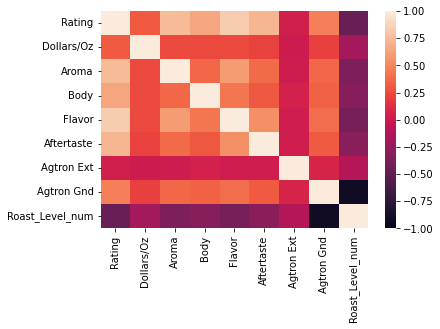

In [132]:
sns.heatmap(data = coffee_df.corr(), vmin = -1, vmax = 1)

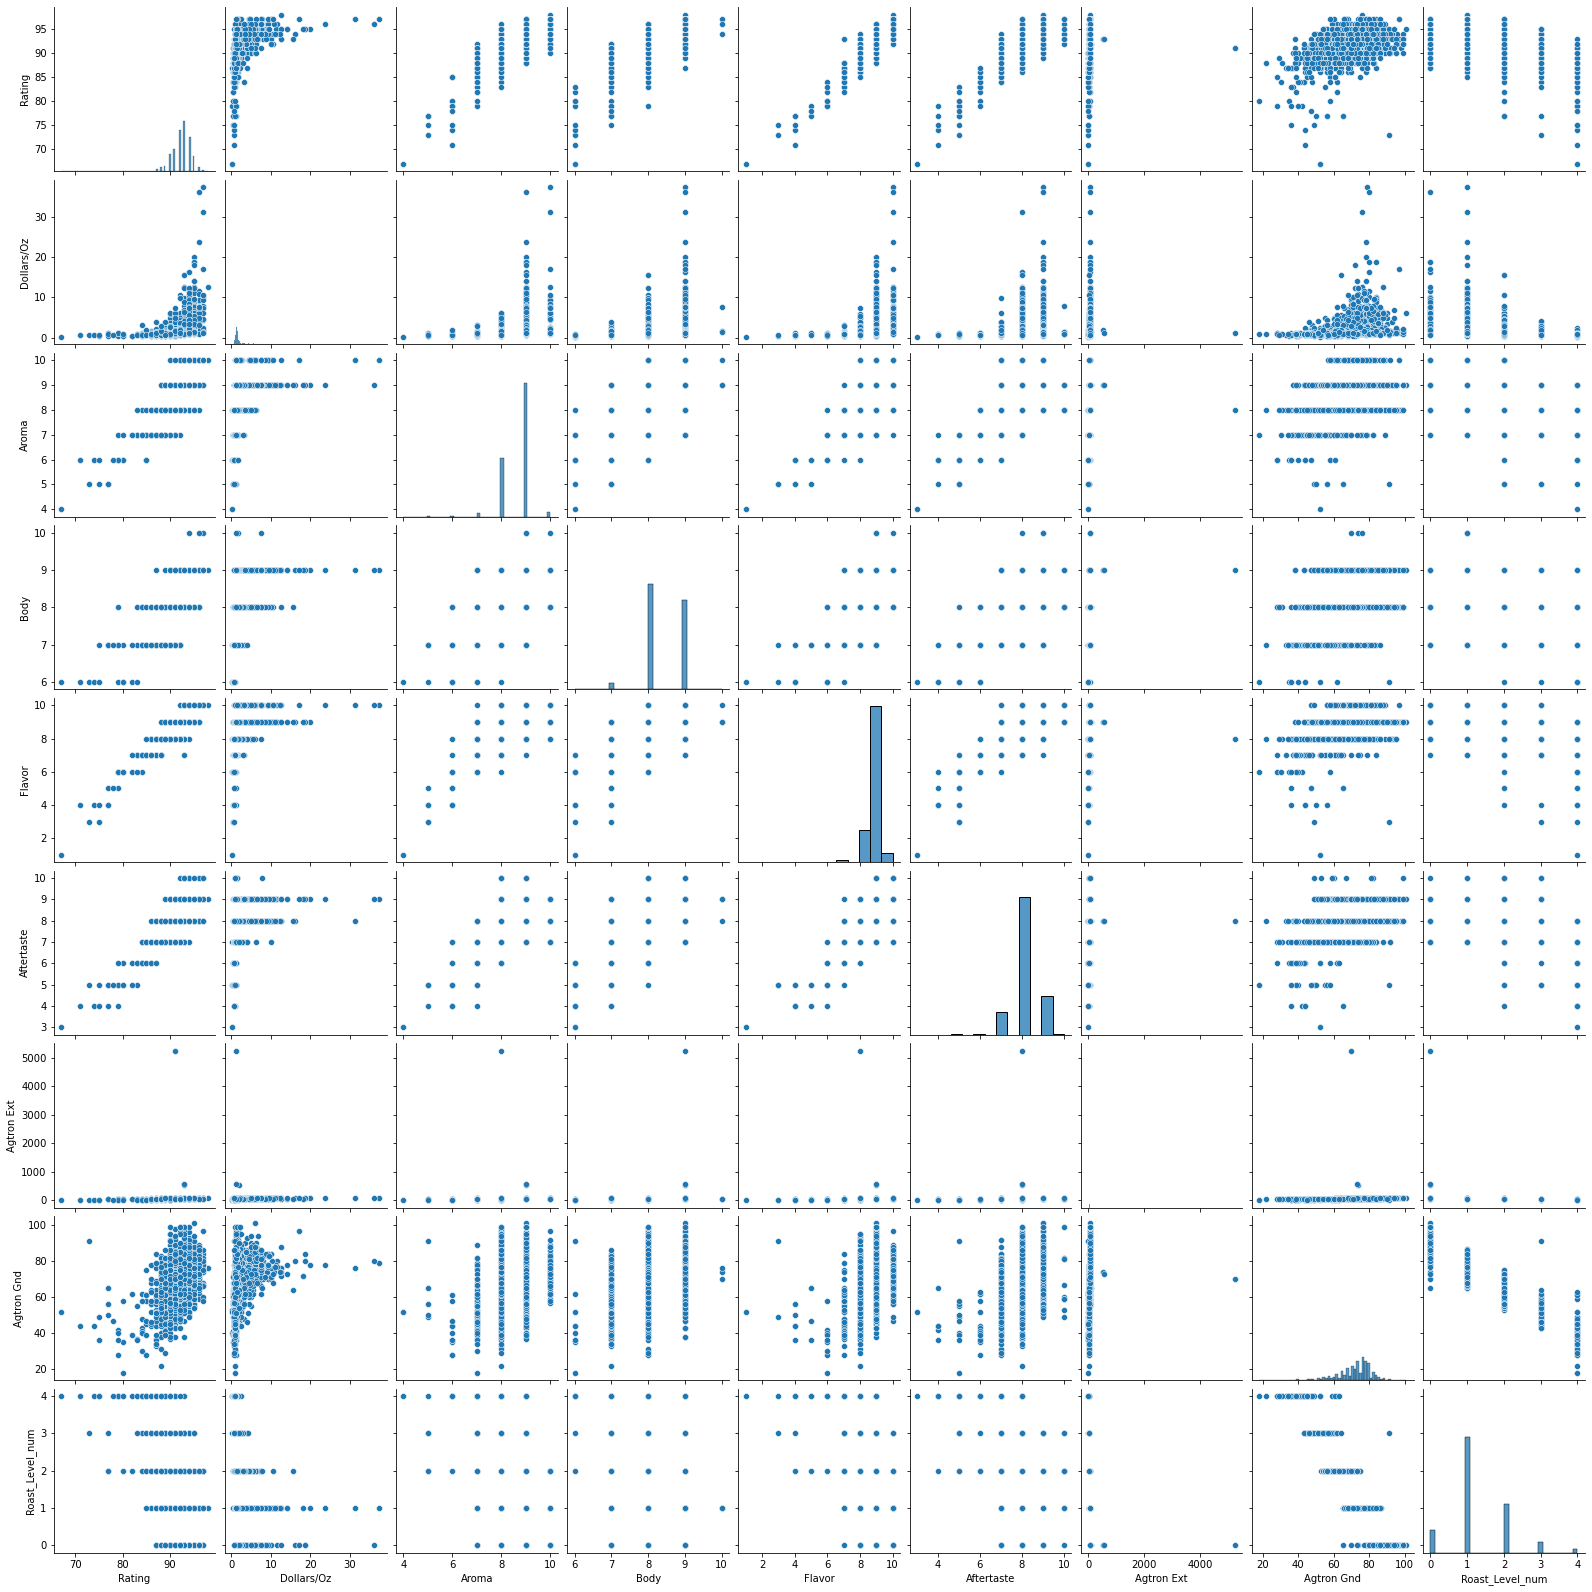

In [133]:
sns.pairplot(coffee_df)

In [120]:
rating_ols = sm.ols(formula="Rating ~ Body + Aroma + Flavor + Aftertaste", data=coffee_df).fit()
rating_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.943
Method:                 Least Squares   F-statistic:                 1.309e+04
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        15:06:02   Log-Likelihood:                -2545.2
No. Observations:                3137   AIC:                             5100.
Df Residuals:                    3132   BIC:                             5131.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     50.7784      0.185    274.529      0.000      50.416      51.141
Body           1.1368      0.019     59.532      0.000       1.099       1.174
Aroma          1.2004      0.021     57.829      0.000       1.160       1.241
Flavor         1.3399      0.023     58.284      0.000       1.295       1.385
Aftertaste     1.2070      0.018     65.632      0.000       1.171       1.243
==============================================================================
Omnibus:                      142.221   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              379.602
Skew:                          -0.213   Prob(JB):                     3.72e-83
Kurtosis:                       4.650   Cond. No.                         325.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [179]:
coffee_df.columns

Index(['Roaster', 'Name', 'Rating', 'Roaster Location', 'Coffee Origin',
       'Roast Level', 'Est. Price', 'Dollars/Oz', 'Review Date', 'Aroma',
       'Body', 'Flavor', 'Aftertaste', 'Agtron Ext', 'Agtron Gnd',
       'Roast_Level_num', 'Value'],
      dtype='object')

In [ ]:
#predicts = coffee_df.drop(["Rating" ,"Roaster", "Name", "Roaster Location", "Coffee Origin", "Roast Level", "Est. Price", "Review Date"], axis=1)
outcome = coffee_df["Name"]
predicts = coffee_df[["Rating","Roast_Level_num", "Dollars/Oz"]]

best_accuracy = 0
best_C = 0
Cs = np.linspace(0.1,200,20)
predicts_train, predicts_test, outcome_train, outcome_test = train_test_split(predicts, outcome, random_state=1, test_size=0.5, train_size=0.5)
accuracies = []
print('start')

for i,C in enumerate(Cs):
    svm_coffee = svm.SVC(kernel="rbf", C = C, gamma="scale")
    svm_coffee.fit(predicts_train, outcome_train)
    outcome_pred = svm_coffee.predict(predicts_test)
    scores = cross_val_score(estimator = svm_coffee, X = predicts_test, y = outcome_pred, cv=5, scoring='accuracy')    
    accuracy = np.mean(scores)
    accuracies.append(accuracy)
    if accuracy > best_accuracy:
        best_C = C
        best_accuracy = accuracy
    print(accuracy)
print("done")

10.621052631578948 0.990439754990741


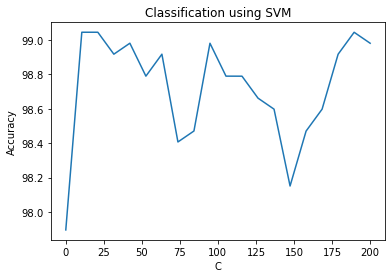

In [175]:
plt.plot(Cs, np.multiply(accuracies, 100))
plt.title("Classification using SVM");
plt.xlabel("C");
plt.ylabel("Accuracy");
print(best_C, best_accuracy)